In [1]:
using CSV, DataFrames, GLM, Statistics, Combinatorics, StatsModels, Plots

### Cargamos los datos

In [2]:
file_path = "bottle.csv"
df = CSV.read(file_path, DataFrame);

## Filtrado de Columnas
Usamos las funciones filter_columns para verificar que columnas son válidas para hacer regresión, se pide que tengan los datos completos hasta en un 93% y que contengan solo valores numéricos

In [3]:
function filter_columns(df, completeness_threshold)
    clean_df = dropmissing(df, names(df))
    num_rows = nrow(df)
    valid_columns = String[]
    for col_name in names(df)
        col = df[:, col_name]
        col_type = clean_df[:, col_name]
        if eltype(col_type) <: Number && count(ismissing, col) / num_rows <= (1 - completeness_threshold)
            push!(valid_columns, string(col_name))  # Asegurar que son nombres en formato String
        end
    end
    return valid_columns
end

  
valid_cols = filter_columns(df, 0.93)
println("Columnas válidas: ", valid_cols)

Columnas válidas: ["Cst_Cnt", "Btl_Cnt", "Depthm", "T_degC", "Salnty", "STheta", "RecInd", "T_prec", "S_prec", "NH3q", "C14A1q", "C14A2q", "DarkAq", "MeanAq", "R_Depth", "R_TEMP", "R_POTEMP", "R_SALINITY", "R_SIGMA", "R_SVA", "R_DYNHT", "R_PRES"]


Limpiamos el DataFrame con solo esas columnas

In [4]:
function clean_dataframe(df::DataFrame, valid_columns::Vector{String})
    # Seleccionar solo las columnas válidas
    df_subset = select(df, intersect(names(df), valid_columns))
    return df_subset
end

# Limpia el DataFrame
df_subset = clean_dataframe(df,valid_cols);
#report_missing_values(df_subset)

## Cálculo de matriz de correlación

Se calcula la matriz de correlación para verificar qué columnas nos podrían dar una regresión adecuada

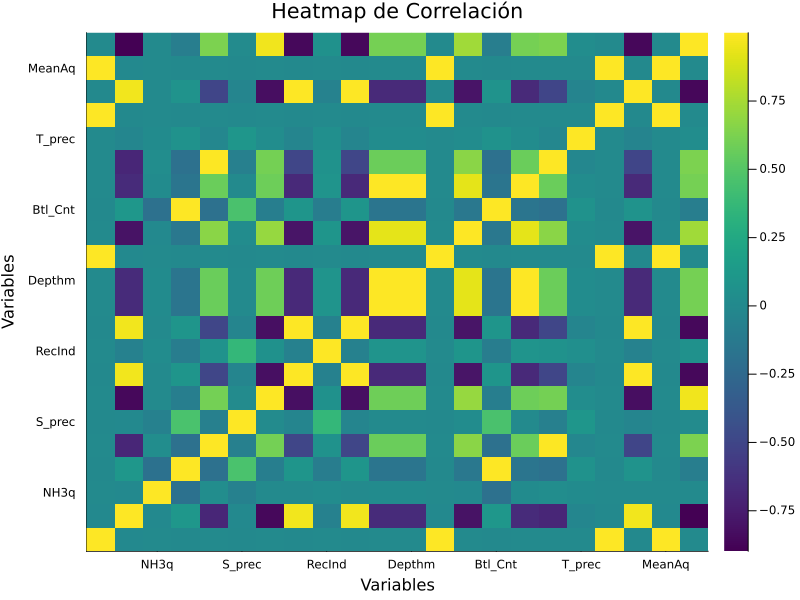

In [5]:
function calculate_correlation(df::DataFrame)
    # Eliminar filas con valores faltantes
    clean_df = dropmissing(df)
    
    # Seleccionar columnas numéricas
    numeric_cols = names(clean_df)[eltype.(eachcol(clean_df)) .<: Number]
    
    # Inicializar matriz de correlaciones
    corr_mat = Dict{String, Dict{String, Float64}}()
    for col1 in numeric_cols
        corr_mat[string(col1)] = Dict(string(col2) => 0.0 for col2 in numeric_cols)
    end
    
    # Calcular las correlaciones
    for i in 1:length(numeric_cols)
        for j in i:length(numeric_cols)
            col1 = numeric_cols[i]
            col2 = numeric_cols[j]
            
            # Seleccionar filas sin valores faltantes para ambas columnas
            valid_rows = .!(ismissing.(df[!, col1]) .| ismissing.(df[!, col2]))
            
            # Si no hay datos suficientes, omitir
            if sum(valid_rows) <= 1
                correlation = NaN
            else
                m1 = mean(df[valid_rows, col1])
                m2 = mean(df[valid_rows, col2])
                cov = mean((df[valid_rows, col1] .- m1) .* (df[valid_rows, col2] .- m2))
                std1 = std(df[valid_rows, col1])
                std2 = std(df[valid_rows, col2])
                correlation = cov / (std1 * std2)
            end
            
            # Actualizar la matriz de correlación simétricamente
            corr_mat[string(col1)][string(col2)] = correlation
            corr_mat[string(col2)][string(col1)] = correlation
        end
    end
    
    return corr_mat
end

function display_correlation(corr_mat::Dict)
    # Extraer nombres de filas y columnas
    rows = collect(keys(corr_mat))
    cols = collect(keys(first(values(corr_mat))))
    
    # Crear la matriz de correlaciones
    matrix = [corr_mat[row][col] for col in cols, row in rows]
    
    # Crear el heatmap
    fig = heatmap(
        cols,       # Las columnas (variables)
        rows,       # Las filas (también variables)
        matrix,     # Los valores de correlación
        color=:viridis,
        title="Heatmap de Correlación",
        xlabel="Variables",
        ylabel="Variables",
        size=(800, 600),
        colorbar=true  # Activar la barra de colores
    )
    
    # Guardar la imagen del heatmap
    savefig("heatmap.png")
    return fig
end

# 1. Calcular la matriz de correlaciones
corr_mat = calculate_correlation(df_subset);

# 2. Mostrar la matriz de correlaciones
display_correlation(corr_mat)

Filtrar columnas por correlación, que tengan un valor absoluto mayor que 0.8

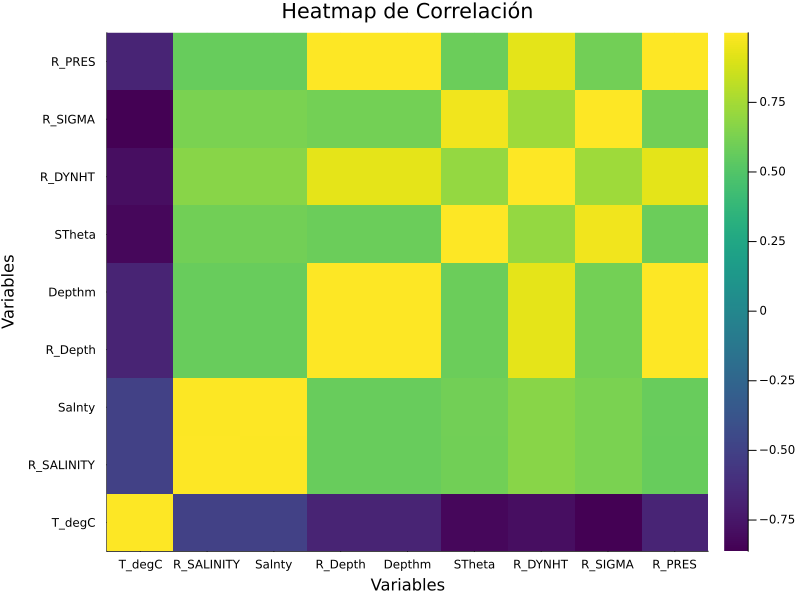

In [6]:
function filter_columns_by_correlation(df::DataFrame, corr_mat::Dict, target::Symbol, threshold::Float64, relation::Bool)
    target_corr = corr_mat[string(target)]
    
    for key in keys(target_corr)
        if key == string(target)
            continue
        end
        
        val = target_corr[key]
        if (!relation && abs(val) ≤ abs(threshold)) || (relation && val ≥ threshold)
            select!(df, Not(Symbol(key)))  # Eliminar columna
        end
    end
    
    return df
end


df1 = filter_columns_by_correlation(df_subset, corr_mat, :T_degC, 0.1, false)
df2 = filter_columns_by_correlation(df_subset, corr_mat, :T_degC, 0.8, true)


corr_new = calculate_correlation(df1)
display_correlation(corr_new)

## Regresión lineal en Julia

Realiza una regresión lineal utilizando el paquete `StatsModels` en Julia. A continuación se explica cada parte de esta línea:

### 1. `lm`

`lm` es una función en Julia que se utiliza para ajustar modelos de regresión lineales. En este caso, se ajusta un modelo lineal de la forma:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n
$$

donde los coeficientes $\beta$ son estimados a partir de los datos.

### 2. `@formula`

La macro `@formula` se utiliza para especificar el modelo de regresión en un formato más legible y estructurado. La fórmula que sigue tiene la siguiente forma:

$$
\text{T\_degC} \sim \text{Depthm} + \text{Salnty} + \text{STheta} + \text{R\_SIGMA}
$$

Esto indica que se quiere predecir la variable dependiente `T_degC` utilizando como variables independientes (predictoras) las columnas `Depthm`, `Salnty`, `STheta` y `R_SIGMA`.


Se filtran las columnas válidas

In [7]:
valid_cols = filter_columns(df1, 0.0)
println("Columnas válidas: ", valid_cols)

Columnas válidas: ["Depthm", "T_degC", "Salnty", "STheta", "R_Depth", "R_SALINITY", "R_SIGMA", "R_DYNHT", "R_PRES"]


Evaluamos el mejor modelo de regresión con el parámetro $R^2$ usando combinaciones de 4 columnas

In [8]:
model_1 = lm(@formula(T_degC ~ Salnty + R_SIGMA + R_DYNHT + R_PRES), df1) 
r2_value = r2(model_1)
println(r2_value)

0.8338449894499264


In [10]:
col_combinations = collect(combinations(valid_cols, 4))
for combo in col_combinations
    col1, col2, col3, col4 = combo
    # Imprimir el nombre de las columnas combinadas
    #println("Evaluando modelo para T_degC ~ $col1 + $col2 + $col3 + $col4")
    
    # Crear la fórmula usando @eval para combinar las dos columnas
    formula = @eval @formula(T_degC ~ $(Symbol(col1)) + $(Symbol(col2))+ $(Symbol(col3))+ $(Symbol(col4)))
    model_1 = lm(formula, df1)
    
    # Obtener el valor de R²
    r2_value = r2(model_1)

    # Imprimir el valor de R²
    println("R² para T_degC ~ $col1 + $col2 + $col3 + $col4 es: ", r2_value)

end

R² para T_degC ~ Depthm + T_degC + Salnty + STheta es: 1.0
R² para T_degC ~ Depthm + T_degC + Salnty + R_Depth es: 1.0
R² para T_degC ~ Depthm + T_degC + Salnty + R_SALINITY es: 1.0
R² para T_degC ~ Depthm + T_degC + Salnty + R_SIGMA es: 1.0
R² para T_degC ~ Depthm + T_degC + Salnty + R_DYNHT es: 1.0
R² para T_degC ~ Depthm + T_degC + Salnty + R_PRES es: 1.0
R² para T_degC ~ Depthm + T_degC + STheta + R_Depth es: 1.0
R² para T_degC ~ Depthm + T_degC + STheta + R_SALINITY es: 1.0
R² para T_degC ~ Depthm + T_degC + STheta + R_SIGMA es: 1.0
R² para T_degC ~ Depthm + T_degC + STheta + R_DYNHT es: 1.0
R² para T_degC ~ Depthm + T_degC + STheta + R_PRES es: 1.0
R² para T_degC ~ Depthm + T_degC + R_Depth + R_SALINITY es: 1.0
R² para T_degC ~ Depthm + T_degC + R_Depth + R_SIGMA es: 1.0
R² para T_degC ~ Depthm + T_degC + R_Depth + R_DYNHT es: 1.0
R² para T_degC ~ Depthm + T_degC + R_Depth + R_PRES es: 1.0
R² para T_degC ~ Depthm + T_degC + R_SALINITY + R_SIGMA es: 1.0
R² para T_degC ~ Depthm + T